In [26]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'H:\My Documents\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [27]:
### Start user input ###
path_to_data = r'H:\My Documents\Capstone data 2' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Function imports
from advanced_dataloading import process_folder
from advanced_preprocessing import frame_waves, valid_velo_data, save_second_scaler, random_noise, duplicate_and_augment_data, flatten_data_distribution, bin_data, calculate_duplication_factors
from models import load_scalers, load_models, LSTMModel, GRUModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [28]:
df = process_folder(path_to_data, path_to_output, plot=False, labels=True)

Binlog data extracted
Processing run: 2024-11-08T120530
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 8928571.42857143, 'flowRate': 180, 'bin_file': '2024-11-08T120530.bin'}
358482000 datapoints extracted
LABELS: 418 bubble labels with VeloOut != -1 extracted.
Saved bubbles to H:\My Documents\Capstone results\180_2024-11-08T120530_bubbles.csv
No missing labels.
EXTRACTED: 418 bubbles have VeloOut != -1 out of 2261 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-08T120530    E0    -1 -1.000000   
1  1_2024-11-08T120530    E1    L0  0.873666   
2  2_2024-11-08T120530    E2    -1 -1.000000   
3  3_2024-11-08T120530    E3    -1 -1.000000   
4  4_2024-11-08T120530    E4    -1 -1.000000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5647144913673401, 0.5805230736732483, 0.572...       180  8.928571e+06  
1  [0.5678884387016296, 0.5362102389335632, 0.563...       180  8.928571e+06  
2 

In [29]:
feature_scaler, target_scaler, X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = save_second_scaler(df)

In [30]:
chance = 0.3
bins = 20
X_train_scaled, y_train_scaled = random_noise(X_train_scaled, y_train_scaled, chance, random_seed = 0)
hist, bin_indices = bin_data(y_train_scaled, bins)
factors = calculate_duplication_factors(hist)
X_train_scaled, y_train_scaled = duplicate_and_augment_data(X_train_scaled, y_train_scaled, bin_indices, factors, noise=0.005)
X_train_scaled, y_train_scaled = flatten_data_distribution(X_train_scaled, y_train_scaled, bins, scaling_factor=0.5, noise=0.005)

In [31]:
X_train_scaled.shape

(4090, 4000)

In [32]:
X_train_tensor = torch.tensor(X_train_scaled[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled[..., np.newaxis], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled[..., np.newaxis], dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

Epoch 1/2000 - Train Loss: 9.3450 - Val Loss: 0.8983
Epoch 100/2000 - Train Loss: 4.4620 - Val Loss: 5.2557
Early stopping triggered at epoch 101


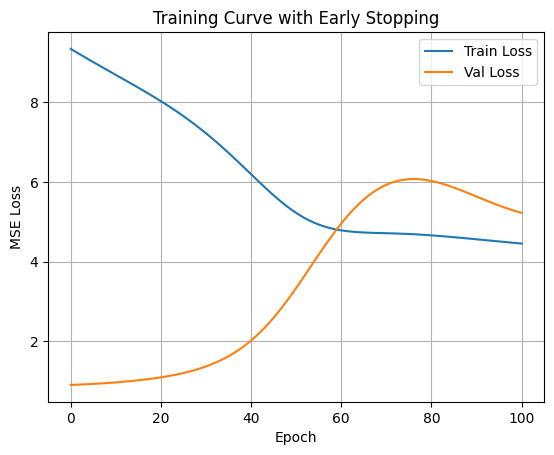

In [39]:
# Model setup
gru1_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1_model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru1_model.parameters(), lr=0.0008)

# Early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru1_model.train()
    optimizer.zero_grad()
    y_pred_train = gru1_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru1_model.eval()
    with torch.no_grad():
        y_pred_val = gru1_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru1_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    gru1_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve with Early Stopping")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Predict on validation set
gru1_model.eval()
with torch.no_grad():
    y_pred_scaled = gru1_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru1 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru1)
mae = mean_absolute_error(y_true, y_pred_gru1)
r2 = r2_score(y_true, y_pred_gru1)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

RMSE: 0.447 cm/s
MAE: 0.625 cm/s
R² Score: -4.974


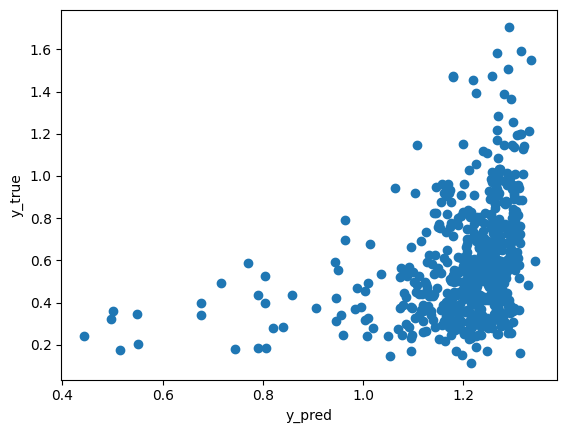

In [41]:
plt.figure()
plt.scatter(y_pred_gru1,y_true)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [ ]:
gru2_model = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru2_model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(gru2_model.parameters(), lr=0.0008)
criterion = torch.nn.MSELoss()

# Early stopping setup
patience = 100
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    gru2_model.train()
    optimizer.zero_grad()
    pred_train = gru2_model(X_train_tensor)
    loss = criterion(pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    gru2_model.eval()
    with torch.no_grad():
        pred_val = gru2_model(X_val_tensor)
        val_loss = criterion(pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = gru2_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    gru2_model.load_state_dict(best_model_state)

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("GRU 2 Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()

Epoch 1/2000 - Train Loss: 10.7564 - Val Loss: 0.8984
Epoch 50/2000 - Train Loss: 6.1437 - Val Loss: 2.0431


In [ ]:
# Predict on validation set
gru2_model.eval()
with torch.no_grad():
    y_pred_scaled = gru2_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_gru2 = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_gru2)
mae = mean_absolute_error(y_true, y_pred_gru2)
r2 = r2_score(y_true, y_pred_gru2)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

In [ ]:
plt.figure()
plt.scatter(y_pred_gru2,y_true)
plt.show()

In [ ]:
lstm_model = LSTMModel(input_size=1, hidden_size=25, num_layers=2)
lstm_model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)

# Early stopping setup
patience = 100
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

# Training loop
epochs = 2000
train_losses, val_losses = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train = lstm_model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    lstm_model.eval()
    with torch.no_grad():
        y_pred_val = lstm_model(X_val_tensor)
        val_loss = criterion(y_pred_val, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = lstm_model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch+1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

# Restore best model weights
if best_model_state is not None:
    lstm_model.load_state_dict(best_model_state)

# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("LSTM Training Curve (with Early Stopping)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Predict on validation set
lstm_model.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model(X_val_tensor).detach().cpu().numpy().flatten()

# Inverse-transform
y_pred_lstm = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = target_scaler.inverse_transform(y_val_tensor.cpu().numpy().reshape(-1, 1)).flatten()

# Metrics
rmse = mean_squared_error(y_true, y_pred_lstm)
mae = mean_absolute_error(y_true, y_pred_lstm)
r2 = r2_score(y_true, y_pred_lstm)

print(f"RMSE: {rmse:.3f} cm/s")
print(f"MAE: {mae:.3f} cm/s")
print(f"R² Score: {r2:.3f}")

In [ ]:
plt.figure()
plt.scatter(y_pred_lstm,y_true)
plt.show()

In [ ]:
with torch.no_grad():  
    y_gru1_scaled = gru1_model(X_test_tensor)
    y_gru2_scaled = gru2_model(X_test_tensor)
    y_lstm_scaled = lstm_model(X_test_tensor)
    
y_gru1 = target_scaler.inverse_transform(y_gru1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2 = target_scaler.inverse_transform(y_gru2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm = target_scaler.inverse_transform(y_lstm_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()

y_pred = ((y_lstm+y_gru1+y_gru2)/3).flatten()
outcome_df = pd.DataFrame({"predictions model 1": y_gru1, "predictions model 2": y_gru2, "predictions model 3": y_lstm, "final prediction": y_pred})
outcome_df['Standard deviation'] = outcome_df[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df['Standard deviation %'] = outcome_df['Standard deviation'] / outcome_df['final prediction'] * 100
 
print(outcome_df.head(10))

In [ ]:
# Evaluation metrics (remove '''...''' if interested)
valid_bubbles_ai = len(outcome_df[outcome_df['Standard deviation %'] < 10])/len(outcome_df) * 100
valid_bubbles_boring_software = len(valid_velo_data(df)[0])/len(df) * 100

X_velo, y_velo = valid_velo_data(df)
X_velo_scaled = torch.tensor(feature_scaler.transform(X_velo)[...,np.newaxis], dtype=torch.float32)
X_velo_scaled = X_velo_scaled.to(device)
with torch.no_grad():  
        y_gru1_scaled_velo = gru1_model(X_velo_scaled)
        y_gru2_scaled_velo = gru2_model(X_velo_scaled)
        y_lstm_scaled_velo = lstm_model(X_velo_scaled)
y_gru1_velo = target_scaler.inverse_transform(y_gru1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2_velo = target_scaler.inverse_transform(y_gru2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm_velo = target_scaler.inverse_transform(y_lstm_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_pred_velo = ((y_lstm_velo+y_gru1_velo+y_gru2_velo)/3).flatten()
outcome_df_valid = pd.DataFrame({"predictions model 1": y_gru1_velo, "predictions model 2": y_gru2_velo, "predictions model 3": y_lstm_velo, "final prediction": y_pred_velo})
outcome_df_valid['Standard deviation'] = outcome_df_valid[["predictions model 1", "predictions model 2", "predictions model 3"]].std(axis=1)
outcome_df_valid['Standard deviation %'] = outcome_df_valid['Standard deviation'] / outcome_df_valid['final prediction'] * 100
valid_test_results = outcome_df_valid[(outcome_df_valid["Standard deviation"]/outcome_df_valid["final prediction"]) <= 0.1]

filtered_outcome_df = outcome_df[outcome_df['Standard deviation %'] < 10]
average_percentage_std = filtered_outcome_df['Standard deviation %'].mean()

print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  {len(valid_test_results) / (len(outcome_df_valid)) * 100:.4f} %")
print(f'Percentage AI found valid bubbles (uncertainty < 10%): {valid_bubbles_ai:.4f} % vs M2 analyzer: {valid_bubbles_boring_software:.4f} %, improvement: {((valid_bubbles_ai - valid_bubbles_boring_software)/valid_bubbles_boring_software)*100:.4f} %')
print(f'Model uncertainty (average uncertainty of valid bubbles): {average_percentage_std:.4f} % with {len(filtered_outcome_df) / len(outcome_df_valid) * 100} % of the labled samples')
